# Practical 3: CIFAR-10

**Shuyue Wang, Yiwen Wang**

This is the second task of Practical 3. Your task is to use **transfer learning** to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to build a classifier for CIFAR-10.

We will mark your code based on the accuracy of your model. 
Your CNN should achieve at least an accuracy of 75% to pass the practical.
You can get 5 or 10 bonus points by achieving an accuracy of 85%+ or 90%+.

You should save and upload your model to the seafile link we provided to you. Please name the model file as `{repository_name}-CIFAR10.h5`. For example, if your repository is FDS21-M0, you should name the model file as `FDS21-M0-CIFAR10.h5`

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.7.0'

In [3]:
tf.keras.__version__

'2.7.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

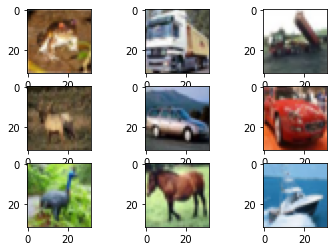

(50000, 32, 32, 3)

In [4]:
from keras.datasets import cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full.shape

In [5]:
from keras.applications.vgg16 import preprocess_input
# vgg16 preprocess
X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test)

# one-hot encoding
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


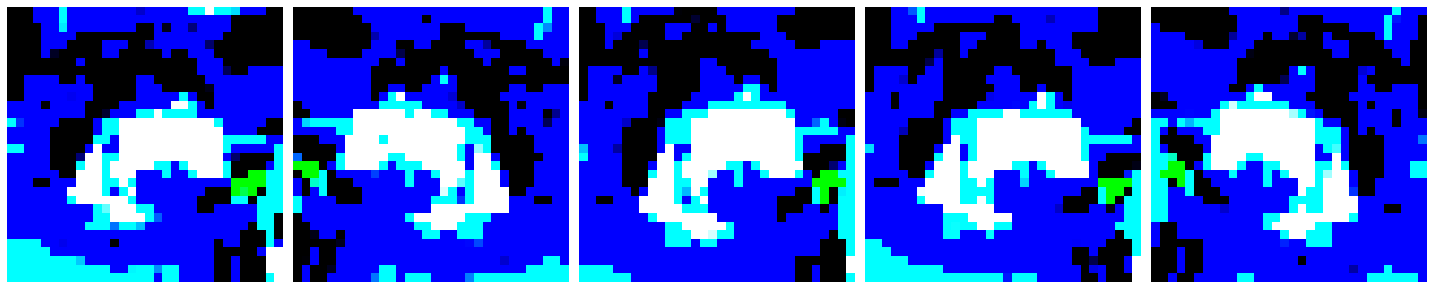

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, zoom_range=0.1)

frog_generator = datagen.flow(X_train_full[:1])
aug_images = [next(frog_generator)[0] for i in range(5)]

def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(aug_images)

In [7]:
X_train_full.shape

(50000, 32, 32, 3)

## Build and train the model

Build and train your model. 

In [18]:
# TODO: load the model you selected
VGG19_model = tf.keras.applications.VGG19(include_top=False, input_shape=(32, 32, 3), weights='imagenet')
# vgg16_model = tf.keras.applications.vgg16.VGG16()
# when you change the input shape, keras will automatically change the shapes of the other layers accordingly . to meet the new input shape
VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [19]:
# TODO: Transfer learning - build your own model based on the selected model
x = VGG19_model.layers[-6].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256,activation='relu')(x) # dense layer 1
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256,activation='relu')(x) # dense layer 2
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
output = keras.layers.Dense(units=10, activation='softmax')(x) # output layer with softmax activation
model = keras.Model(inputs=VGG19_model.input, outputs=output)

# freeze the layers from VGG16 
for layer in VGG19_model.layers:
    layer.trainable=False


In [20]:
# show the structure of your model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [21]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=["accuracy"])

C:\Users\amber\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
train_data_generator= datagen.flow(X_train, y_train, batch_size=64)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_data_generator, 
          steps_per_epoch = len(X_train) / 64,
          epochs=40,
          validation_data=(X_valid, y_valid),
          callbacks=[early_stopping_cb])

Epoch 1/40
703/703 [==============================] - 190s 269ms/step - loss: 1.0189 - accuracy: 0.6484 - val_loss: 0.7473 - val_accuracy: 0.7528
Epoch 2/40
703/703 [==============================] - 194s 276ms/step - loss: 0.8163 - accuracy: 0.7149 - val_loss: 0.7367 - val_accuracy: 0.7526
Epoch 3/40
703/703 [==============================] - 198s 282ms/step - loss: 0.7640 - accuracy: 0.7321 - val_loss: 0.7051 - val_accuracy: 0.7756
Epoch 4/40
703/703 [==============================] - 199s 283ms/step - loss: 0.7294 - accuracy: 0.7434 - val_loss: 0.7272 - val_accuracy: 0.7630
Epoch 5/40
703/703 [==============================] - 198s 282ms/step - loss: 0.7089 - accuracy: 0.7508 - val_loss: 0.6576 - val_accuracy: 0.7672
Epoch 6/40
703/703 [==============================] - 200s 285ms/step - loss: 0.6908 - accuracy: 0.7554 - val_loss: 0.6423 - val_accuracy: 0.7744
Epoch 7/40
703/703 [==============================] - 201s 286ms/step - loss: 0.6779 - accuracy: 0.7620 - val_loss: 0.6092 -

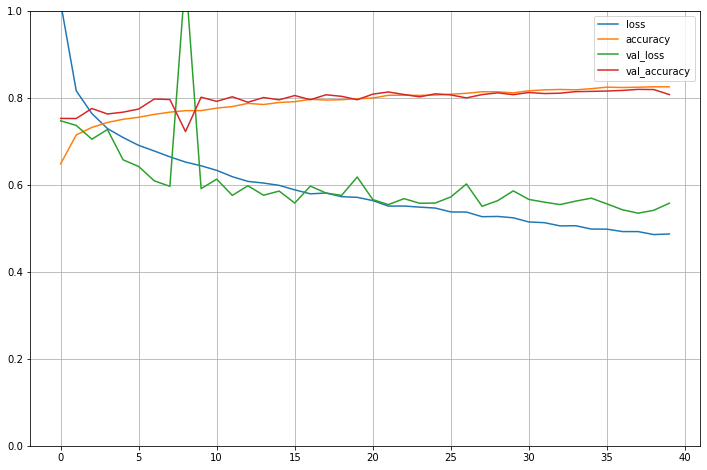

In [23]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

Save and upload your trained model to the seafile link we provided to you. You can upload it multiple times. We will consider only the newest uploaded model. 

In [24]:
model.save('FDS21-M101-CIFAR10.h5') # change the file name according to your repository name

## Load the model and evaluate it on the test data

In [26]:
model = keras.models.load_model('FDS21-M101-CIFAR10.h5')
model.evaluate(X_test, y_test)

313/313 [==============================] - 38s 120ms/step - loss: 0.5821 - accuracy: 0.8027


[0.5821014642715454, 0.8026999831199646]

## Short report

Please write a few sentences explaining how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

1. Firstly, before deciding to use which structure provided by the Keras, we need to figure out difference between these models. We tried to print out the structure of different CNN models using summary. It is clear that after VGG19, the number of layers and nuerons of the models increase drastically. 
2. We then tried to use a more complex one which usually means more powerful ability to learn. However, the data set is not big enough to train the model. We observed the training accuracy and loss accuracy did not converge after 30 and 35 epoches, even though we have already used the data argumentation. 
3. We decided to use VGG19 with less layers and parameters. 
4. Due to the val_accuracy vibrated, we then tried to increase the batch size.
5. However, the model did not converge. Thus, we changes epoches from 30 to 40.
After step 3, we observed that the accuracy reached the baseline but not very excellent. 
Difficulties including:
1. when we tried to work out how large the data set would be to train such a complicated model, we only can refer to some published paper and did not find a way to estimate the size by ourselves.
2. Complex model means more powerful learning ability, which also need a larger data set to support the training process.
3. How to alter the hyperparameters to find the optimal? We tried use the established model in some papers and are still wondering if there is any methods to test different composition of these parameters beforehead instead of taking too much on training.
4. Learning curve can show the model performance, but for the reasons behind the different results may not be clear for us.